The goal of this figure is to show zonal-mean-zonal wind impacts in time-latitude space. This view will allow us to see latitudes and times of the most significant volcanic impacts for fixed pressure levels. The latitude domain stretches from pole to pole, and the time domain covers the first 3 years post-eruption.

In [1]:
import sys
import pdb
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 12,   # X-axis tick labels
    'ytick.labelsize' : 12,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil

In [2]:
# ----- define pressure levels to plot, in hPa
pp   = [1, 10, 30]
nlev = len(pp)

# ----- get U data
udir = putil.get_daily_variable('U', skip_nosrctag=True)

# ----- extract data at pressure levels
u        = udir['ensmean'].sel(plev=pp, method='nearest')
u_cf     = udir['cfmean'].sel(plev=pp, method='nearest')
u_impact = udir['impact'].sel(plev=pp, method='nearest')
u_pval   = udir['pval'].sel(plev=pp, method='nearest')

# ----- nan insignificant values
u_impact_filtered = u_impact.where(u_pval < 0.05)#, other=0)

# ----- get dims
time, lat, plev = u.time, u.lat, u.plev
plev = sorted(plev.values)
time = [datetime(t.year,t.month,t.day) for t in time.values]

# ----- set lat, time limits
latlim  = [-80, 80]
timelim = [time[0], datetime(time[0].year+2,time[0].month,time[0].day)]


-------- processing ensemble zonal mean data...
doing slicing and averaging...
merging data
ensemble members found: 13
data shape after member concat: (13, 180, 72, 222)
cf shape after member concat: (13, 180, 72, 222)
getting impact
getting data ensemble mean
getting cf ensemble mean
getting impact ensemble mean
getting ttest
getting coherence


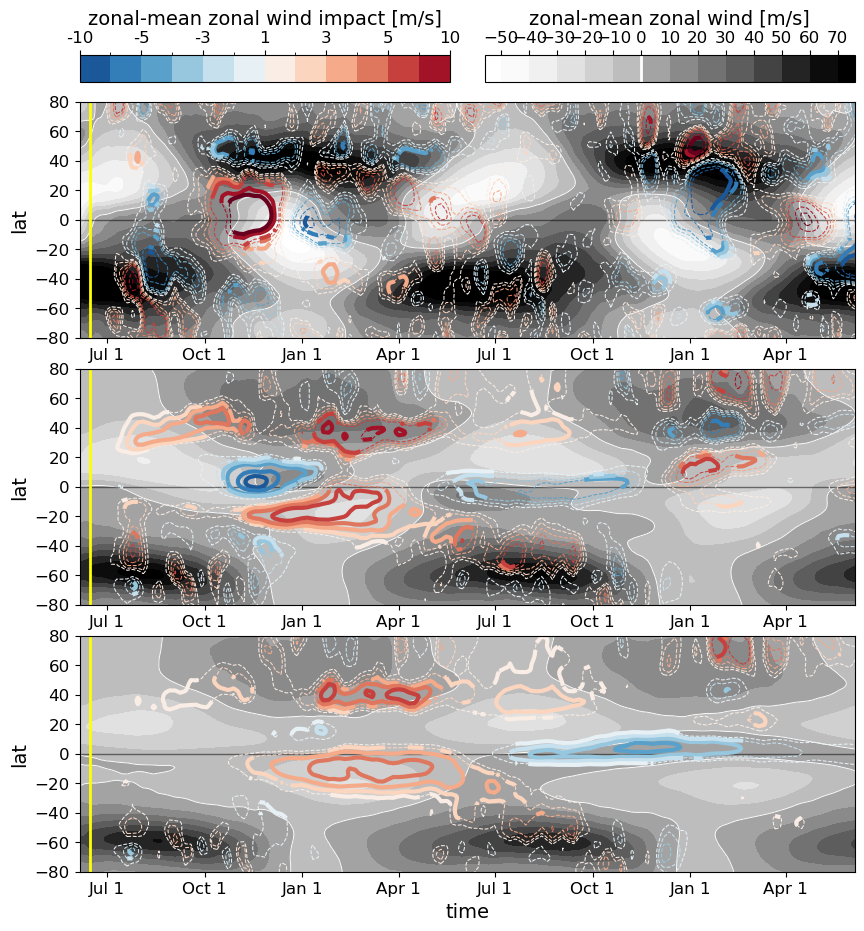

In [3]:
# ----- make figure, with vertically stacked axes per each pressure level
fig_width = 10
fig = plt.figure(figsize=(fig_width, (fig_width/3)*nlev))
ax = []
for i in range(nlev):
    ax.append(fig.add_subplot(nlev, 1, i+1))
    
# ----- ploting settings
cmap   = 'Greys'  # data colormap
zcolor = 'w'      # data zero-line color
zlw    = 0.66     # data zero-line linewidth
icmap  = 'RdBu_r' # impact colormap
ilw    = 0.75      # impact linewidth
ils    = '--'     # impact linestyle
ilwsig = 3      # impact significant linewidth
    
# ----- configure levels
lev   = np.arange(-50, 80, 10)
#ilev  = [-6, -5, -4, -3, -2, 1.5, 2, 3, 4, 5]
#ilev = np.arange(-10, 11, 2)
ilev = [-10, -8, -5, -4, -3, -2, 1.2, 2, 3, 4, 5, 8, 10]
inorm = putil.get_cmap_norm(ilev, 'uneven')
    
# ----- plot data
for i in range(len(plev)):
    p = plev[i]
    
    # --- ensemble data
    cfu  = ax[i].contourf(time, lat, u_cf.sel(plev=p), cmap=cmap, levels=lev, 
                          extend='both')
    ax[i].contour(time, lat, u_cf.sel(plev=p), colors=zcolor, linewidths=zlw, levels=[0]) # zero line
    
    # --- equator
    ax[i].axhline(y=0, color='k', ls='-', lw=1, alpha=0.5)
    # --- eruption
    ax[i].axvline(x=datetime(1991, 6, 15), color='yellow', ls='-', lw=2)
    
    # --- impact data
    ax[i].contour(time, lat, u_impact.sel(plev=p), cmap=icmap, levels=ilev, 
                  norm=inorm, linewidths=ilw, linestyles=ils)
    ax[i].contour(time, lat, u_impact_filtered.sel(plev=p), cmap=icmap, 
                         levels=ilev, norm=inorm, linewidths=ilwsig)
    # dummy plot for impact colorbar
    cfui = ax[i].contourf(time, lat, u_impact.sel(plev=p), cmap=icmap, levels=ilev, 
                          norm=inorm, alpha=0)
    
    # --- pval
    #ax[i].contour(time, lat, u_pval.sel(plev=p), colors='lime', levels=[0.05], linewidths=0.66)
    
    
# ----- make colorbars
# - ensmean
#cbar = fig.colorbar(cfu, cax=fig.add_axes([0.93, 0.51, 0.02, 0.37]), extendrect=True)
cbar = fig.colorbar(cfu, cax=fig.add_axes([0.53, 0.9, 0.37, 0.027]), extendrect=True,
                    orientation='horizontal', location='top')
cbar.set_label('zonal-mean zonal wind [m/s]')
cbar.set_ticks(lev)
cbar.ax.axvline(x=0, color='w', lw=2)

# - impact
#icbar = fig.colorbar(cfui, cax=fig.add_axes([0.93, 0.11, 0.02, 0.37]))
icbar = fig.colorbar(cfui, cax=fig.add_axes([0.125, 0.9, 0.37, 0.027]), 
                     orientation='horizontal', location='top')
icbar.solids.set_alpha(1)
icbar.set_label('zonal-mean zonal wind impact [m/s]')
icbar.set_ticklabels(np.array(ilev).astype(int))

# ----- format
for axi in ax:
    putil.season_timeticks(axi.xaxis, time, 'season')
    axi.set_ylabel('lat')
ax[-1].set_xlabel('time')
    
# ----- set axis ticks, limits
for axi in ax:
    axi.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80])
    axi.set_ylim(latlim)
    axi.set_xlim(timelim)
ax[-1].set_xlabel('time')

plt.subplots_adjust(hspace=0.13)

# ---- overlay latbands and times for reference
if(0):
    for axi in ax:
        axi.fill_between(x=time, y1=50, y2=30, color='cyan', interpolate=True, alpha=.33)
        axi.fill_between(x=time, y1=5, y2=-5, color='cyan', interpolate=True, alpha=.33)
        axi.fill_between(x=time, y1=-30, y2=-50, color='cyan', interpolate=True, alpha=.5)
        #axi.axvspan(datetime(1991,8,15), datetime(1991,11,15), alpha=0.5, color='cyan')
        #axi.axvspan(datetime(1992,7,15), datetime(1992,9,1), alpha=0.5, color='cyan')

#plt.savefig('figs/lat_time_uimpact.png', dpi=200)
plt.show()

Now let's compute the U-tendency budget for the identified latitude bands. In each band, we will do a weighted meridional average on utendepfd, utendresvel, utend, and utdiff, and then plot these as a time series per vertical level

In [16]:
latmin, latmax = 30, 50

# ----- get tendencies
UT       = putil.get_daily_variable('UTEND', latmin=latmin, latmax=latmax)
UTEPFD   = putil.get_daily_variable('utendepfd', latmin=latmin, latmax=latmax)
UTRESVEL = putil.get_daily_variable('UTRESVEL', latmin=latmin, latmax=latmax)
UTDIFF   = putil.get_daily_variable('UTDIFF', latmin=latmin, latmax=latmax)
U        = putil.get_daily_variable('U', latmin=latmin, latmax=latmax)
# ----- nan insignificant values
UT_impact_filt       = UT['impact'].where(UT['pval'] < 0.05)
UTEPFD_impact_filt   = UTEPFD['impact'].where(UTEPFD['pval'] < 0.05)
UTRESVEL_impact_filt = UTRESVEL['impact'].where(UTRESVEL['pval'] < 0.05)
UTDIFF_impact_filt   = UTDIFF['impact'].where(UTDIFF['pval'] < 0.05)

# ----- get integrated tendencies
if(1):
    #UT_INT       = putil.get_daily_variable('UTEND_INT', latmin=latmin, latmax=latmax)
    UTEPFD_INT   = putil.get_daily_variable('UTEPFD_INT', latmin=latmin, latmax=latmax)
    UTRESVEL_INT = putil.get_daily_variable('UTRESVEL_INT', latmin=latmin, latmax=latmax)
    UTDIFF_INT   = putil.get_daily_variable('UTDIFF_INT', latmin=latmin, latmax=latmax)
    # ----- nan insignificant values
    #3UT_INT_impact_filt       = UT_INT['impact'].where(UT_INT['pval'] < 0.05)
    UTEPFD_INT_impact_filt   = UTEPFD_INT['impact'].where(UTEPFD_INT['pval'] < 0.05)
    UTRESVEL_INT_impact_filt = UTRESVEL_INT['impact'].where(UTRESVEL_INT['pval'] < 0.05)
    UTDIFF_INT_impact_filt   = UTDIFF_INT['impact'].where(UTDIFF_INT['pval'] < 0.05)

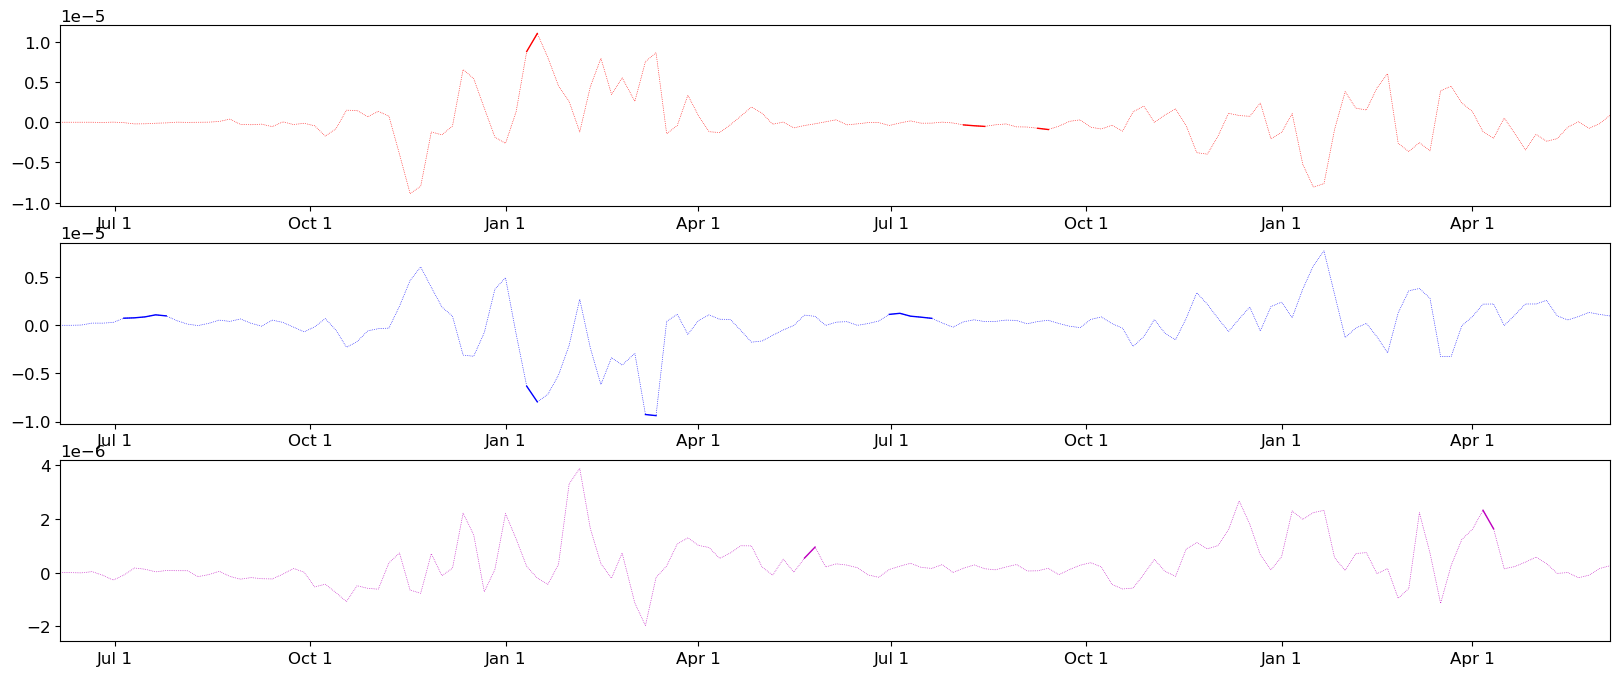

In [11]:
fig = plt.figure(figsize=(20, 8))
parg = {'plev':10, 'method':'nearest'}
UU = U['impact'].sel(**parg)

# plot tendency impact and impact
ax1 = fig.add_subplot(311)
ax1.plot(time, UTEPFD_impact_filt.sel(**parg), '-r', lw=1)
ax1.plot(time, UTEPFD['impact'].sel(**parg), ':r', lw=0.5)
ax2 = fig.add_subplot(312)
ax2.plot(time, UTRESVEL_impact_filt.sel(**parg), '-b', lw=1)
ax2.plot(time, UTRESVEL['impact'].sel(**parg), ':b', lw=0.5)
ax3 = fig.add_subplot(313)
ax3.plot(time, UTDIFF_impact_filt.sel(**parg), '-m', lw=1)
ax3.plot(time, UTDIFF['impact'].sel(**parg), ':m', lw=0.5)

for ax in [ax1, ax2, ax3]:
    putil.season_timeticks(ax.xaxis, time, 'season')
    ax.set_xlim(timelim)
    #ax.set_ylim([-1, 1])
plt.show()

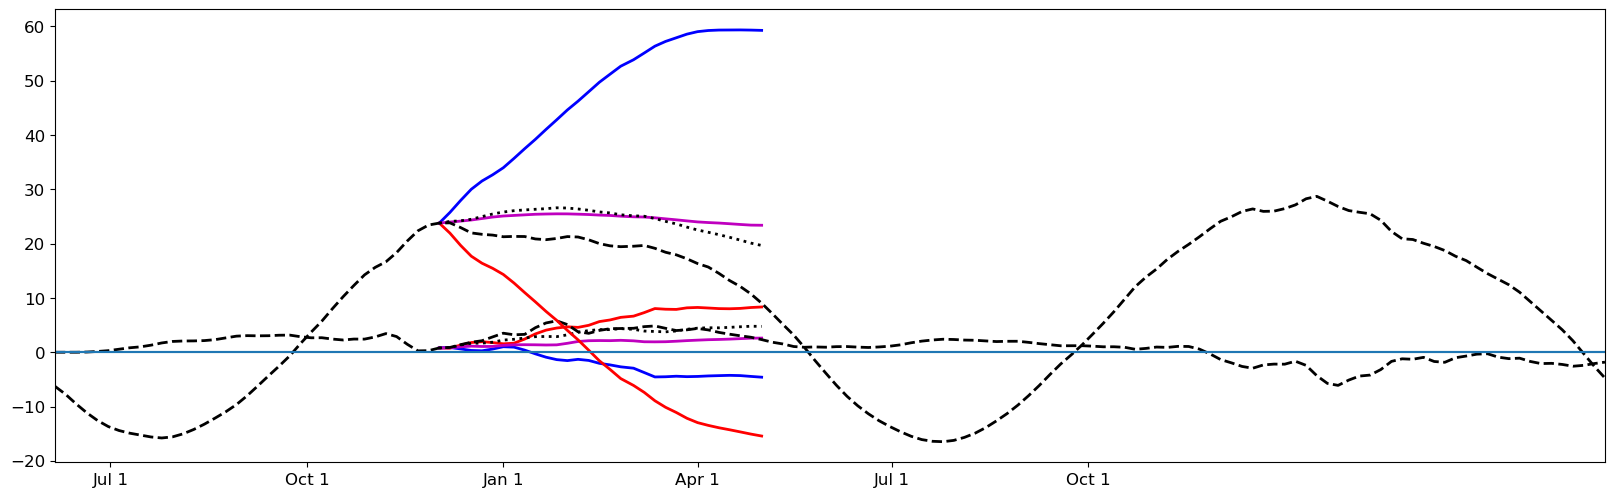

In [70]:
# same thing, but with cumulative sum beginning at specific time...

fig = plt.figure(figsize=(20, 20))
parg = {'plev':10, 'method':'nearest'}
timearg = {'time':slice(date(1991, 12, 1), date(1992, 5, 1))}
alltime = UTEPFD['impact'].time
alltime = alltime.sel(time=slice(alltime[0], date(1993, 6, 1)))
time = alltime.sel(**timearg)
time = [datetime(t.year,t.month,t.day) for t in time.values]

UU = U['impact'].sel(**parg).sel(time=slice(alltime[0], alltime[-1]))
UU0 = UU.sel(**timearg).isel(time=0)
factor = (24*60*60) # seconds per 10 days; each point (10-day average) should be expressing a tendency in m/s/(10 day)
# but because the current value's units are m/s/s... the tendencies appear much to small when integrated...

ue = UTEPFD['impact'].sel(**parg).sel(**timearg).cumsum('time')*factor
ue0 = ue.isel(time=0)
ue = ue-ue0 + UU0
urv = UTRESVEL['impact'].sel(**parg).sel(**timearg).cumsum('time')*factor
urv0 = urv.isel(time=0)
urv = urv-urv0 + UU0
udf = UTDIFF['impact'].sel(**parg).sel(**timearg).cumsum('time')*factor
udf0 = udf.isel(time=0)
udf = udf-udf0 + UU0
utot = ue+urv+udf
utot = (ue+urv+udf)-2*UU0


# Ok realizing something... WHAT I NEED: integrated tendecnies from time 0. I can choose a time to "zero" the tendency
# as POST PROCESSING. Then, impat can be calculated? and then adding the iitial condition is just a constant shift that
# should not change anything?? Or does the initial condition need to be set per-member?? Not clear. But I might already
# have the data computed to do this (as the integration method 2, which was a cumulative trapezoid rule?), either way... 
# should probbaly polt it in BOTH impact and CF... need to write a separate function to do all of this for any choice of
# starting date PER-MEMBER, and then continue on with the impact computation code...
# yea so... currently in this little test I am doing this on the 10-daily averaged data... a terrible idea. The tendencies
# must be integrated before averaging, else they are uselessly smoothed out. It makes more sense, however, for the 
# integrated quantity to be averaged, since this one should vary over much longer timescales

# plot tendency impact and impact
ax1 = fig.add_subplot(311)
ax1.plot(time, ue, '-r', lw=2)
ax1.plot(time, urv, '-b', lw=2)
ax1.plot(time, udf, '-m', lw=2)
ax1.plot(alltime, UU, '--k', lw=2)
ax1.plot(time, utot, ':k', lw=2)
ax1.axhline(y=0)

for ax in [ax1, ax2, ax3]:
    putil.season_timeticks(ax.xaxis, time, 'season')
    #ax.set_xlim([time[0], time[-1]])
    #ax.set_ylim([-1, 1])
    
# SAME THING FOR CF
#fig = plt.figure(figsize=(20, 20))
parg = {'plev':10, 'method':'nearest'}
timearg = {'time':slice(date(1991, 12, 1), date(1992, 5, 1))}
alltime = UTEPFD['cfmean'].time
alltime = alltime.sel(time=slice(alltime[0], date(1993, 6, 1)))
time = alltime.sel(**timearg)
time = [datetime(t.year,t.month,t.day) for t in time.values]

UU = U['cfmean'].sel(**parg).sel(time=slice(alltime[0], alltime[-1]))
UU0 = UU.sel(**timearg).isel(time=0)
factor = (24*60*60) # seconds per 10 days; each point (10-day average) should be expressing a tendency in m/s/(10 day)
# but because the current value's units are m/s/s... the tendencies appear much to small when integrated...

ue = UTEPFD['cfmean'].sel(**parg).sel(**timearg).cumsum('time')*factor
ue0 = ue.isel(time=0)
ue = ue-ue0 + UU0
urv = UTRESVEL['cfmean'].sel(**parg).sel(**timearg).cumsum('time')*factor
urv0 = urv.isel(time=0)
urv = urv-urv0 + UU0
udf = UTDIFF['cfmean'].sel(**parg).sel(**timearg).cumsum('time')*factor
udf0 = udf.isel(time=0)
udf = udf-udf0 + UU0
utot = (ue+urv+udf)-2*UU0

# plot tendency impact and impact
#ax1 = fig.add_subplot(311)
ax1.plot(time, ue, '-r', lw=2)
ax1.plot(time, urv, '-b', lw=2)
ax1.plot(time, udf, '-m', lw=2)
ax1.plot(alltime, UU, '--k', lw=2)
ax1.plot(time, utot, ':k', lw=2)
ax1.axhline(y=0)

for ax in [ax1, ax2, ax3]:
    putil.season_timeticks(ax.xaxis, time, 'season')
    ax.set_xlim([alltime[0], alltime[-1]])
    #ax.set_ylim([-1, 1])
plt.show()

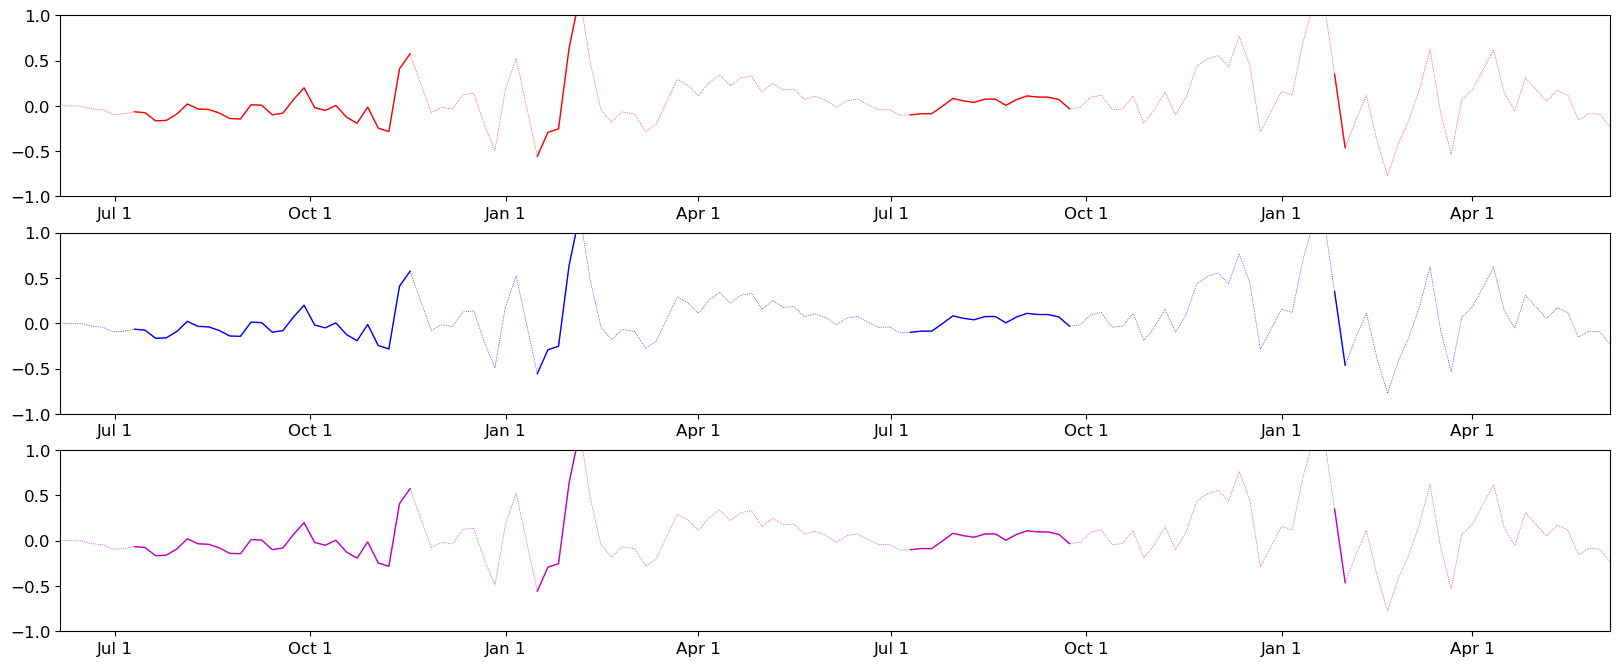

In [14]:
fig = plt.figure(figsize=(20, 8))
parg = {'plev':10, 'method':'nearest'}
UU = U['impact'].sel(**parg)

# plot tendency impact and impact
ax1 = fig.add_subplot(311)
ax1.plot(time, UTEPFD_INT_impact_filt.sel(**parg)-UU, '-r', lw=1)
ax1.plot(time, UTEPFD_INT['impact'].sel(**parg)-UU, ':r', lw=0.5)
ax2 = fig.add_subplot(312)
ax2.plot(time, UTRESVEL_INT_impact_filt.sel(**parg)-UU, '-b', lw=1)
ax2.plot(time, UTRESVEL_INT['impact'].sel(**parg)-UU, ':b', lw=0.5)
ax3 = fig.add_subplot(313)
ax3.plot(time, UTDIFF_INT_impact_filt.sel(**parg)-UU, '-m', lw=1)
ax3.plot(time, UTDIFF_INT['impact'].sel(**parg)-UU, ':m', lw=0.5)

for ax in [ax1, ax2, ax3]:
    putil.season_timeticks(ax.xaxis, time, 'season')
    ax.set_xlim(timelim)
    ax.set_ylim([-1, 1])
plt.show()

Scratch code below for tests of different integration methods...

getting data for variable UTEND...
getting data for variable utendepfd...
getting data for variable UTRESVEL...
getting data for variable UTDIFF...
getting data for variable U...
getting data for variable UTEND_INT...
getting data for variable UTEPFD_INT...
getting data for variable UTRESVEL_INT...
getting data for variable UTDIFF_INT...
getting data for variable UTEND_INT2...
getting data for variable UTEPFD_INT2...
getting data for variable UTRESVEL_INT2...
getting data for variable UTDIFF_INT2...
getting data for variable UTEND_INT3...
getting data for variable UTEPFD_INT3...
getting data for variable UTRESVEL_INT3...
getting data for variable UTDIFF_INT3...
getting data for variable UTEND_INT4...
getting data for variable UTEPFD_INT4...
getting data for variable UTRESVEL_INT4...
getting data for variable UTDIFF_INT4...


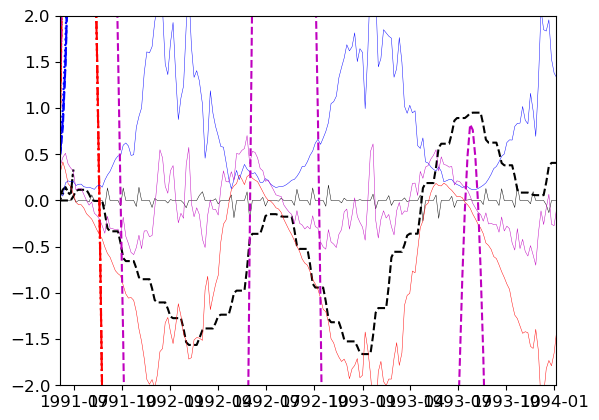

In [33]:
# tendencies
UTEND         = putil.get_daily_variable('UTEND', latmin=35, latmax=45)
utendepfd     = putil.get_daily_variable('utendepfd', latmin=35, latmax=45)
UTRESVEL      = putil.get_daily_variable('UTRESVEL', latmin=35, latmax=45)
UTDIFF        = putil.get_daily_variable('UTDIFF', latmin=35, latmax=45)
U             = putil.get_daily_variable('U', latmin=35, latmax=45)

# integrated tendencies
if(1):
    UTEND_int1     = putil.get_daily_variable('UTEND_INT', latmin=35, latmax=45)
    UTEPFD_int1 = putil.get_daily_variable('UTEPFD_INT', latmin=35, latmax=45)
    UTRESVEL_int1  = putil.get_daily_variable('UTRESVEL_INT', latmin=35, latmax=45)
    UTDIFF_int1    = putil.get_daily_variable('UTDIFF_INT', latmin=35, latmax=45)
    UTEND_int2     = putil.get_daily_variable('UTEND_INT2', latmin=35, latmax=45)
    UTEPFD_int2 = putil.get_daily_variable('UTEPFD_INT2', latmin=35, latmax=45)
    UTRESVEL_int2  = putil.get_daily_variable('UTRESVEL_INT2', latmin=35, latmax=45)
    UTDIFF_int2    = putil.get_daily_variable('UTDIFF_INT2', latmin=35, latmax=45)
    UTEND_int3     = putil.get_daily_variable('UTEND_INT3', latmin=35, latmax=45)
    UTEPFD_int3 = putil.get_daily_variable('UTEPFD_INT3', latmin=35, latmax=45)
    UTRESVEL_int3  = putil.get_daily_variable('UTRESVEL_INT3', latmin=35, latmax=45)
    UTDIFF_int3    = putil.get_daily_variable('UTDIFF_INT3', latmin=35, latmax=45)
    UTEND_int4     = putil.get_daily_variable('UTEND_INT4', latmin=35, latmax=45)
    UTEPFD_int4 = putil.get_daily_variable('UTEPFD_INT4', latmin=35, latmax=45)
    UTRESVEL_int4  = putil.get_daily_variable('UTRESVEL_INT4', latmin=35, latmax=45)
    UTDIFF_int4    = putil.get_daily_variable('UTDIFF_INT4', latmin=35, latmax=45)

# ----- extract data at pressure levels
pp = 10

# ----- nan insignificant values
ut_impact_filt       = ut_impact.where(ut_pval < 0.05)
utepfd_impact_filt   = utepfd_impact.where(utepfd_pval < 0.05)
utresvel_impact_filt = utresvel_impact.where(utresvel_pval < 0.05)
utdiff_impact_filt   = utdiff_impact.where(utdiff_pval < 0.05)

# ----- plot
UU = U['ensmean'].sel(plev=pp, method='nearest')
#plt.plot(time, UU, 'k-')
plt.plot(time, UTEND_int1['ensmean'].sel(plev=pp, method='nearest')-UU, 'k-', lw=0.33)
plt.plot(time, UTEND_int2['ensmean'].sel(plev=pp, method='nearest')-UU, 'k--')
plt.plot(time, UTEND_int3['ensmean'].sel(plev=pp, method='nearest')-UU, 'k-.')
plt.plot(time, UTEND_int4['ensmean'].sel(plev=pp, method='nearest')-UU, 'k:')

plt.plot(time, UTEPFD_int1['ensmean'].sel(plev=pp, method='nearest')-UU, 'r-', lw=0.33)
plt.plot(time, UTEPFD_int2['ensmean'].sel(plev=pp, method='nearest')-UU, 'r--')
plt.plot(time, UTEPFD_int3['ensmean'].sel(plev=pp, method='nearest')-UU, 'r-.')
plt.plot(time, UTEPFD_int4['ensmean'].sel(plev=pp, method='nearest')-UU, 'r:')

plt.plot(time, UTRESVEL_int1['ensmean'].sel(plev=pp, method='nearest')-UU, 'b-', lw=0.33)
plt.plot(time, UTRESVEL_int2['ensmean'].sel(plev=pp, method='nearest')-UU, 'b--')
plt.plot(time, UTRESVEL_int3['ensmean'].sel(plev=pp, method='nearest')-UU, 'b-.')
plt.plot(time, UTRESVEL_int4['ensmean'].sel(plev=pp, method='nearest')-UU, 'b:')

plt.plot(time, UTDIFF_int1['ensmean'].sel(plev=pp, method='nearest')-UU, 'm-', lw=0.33)
plt.plot(time, UTDIFF_int2['ensmean'].sel(plev=pp, method='nearest')-UU, 'm--')
plt.plot(time, UTDIFF_int3['ensmean'].sel(plev=pp, method='nearest')-UU, 'm-.')
plt.plot(time, UTDIFF_int4['ensmean'].sel(plev=pp, method='nearest')-UU, 'm:')



plt.xlim(timelim)
plt.ylim([-2, 2])
plt.show()